# Решение задачи классификации для прогнозирования оттока клиентов банка

В нашем распоряжении исторические данные о поведении клиентов и расторжении договоров с банком. 

Спрогнозируем, уйдёт клиент из банка в ближайшее время или нет. 

Задача - построить модель с предельно большим значением *F1*-меры и довести эту метрику до 0.59,  проверить *F1*-меру на тестовой выборке.  

Дополнительно будем измерять *AUC-ROC*, сравнивая её значение с *F1*-мерой.  

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Содержание
- [Описание данных](#0)
1. [Исследовательский анализ данных](#1)    
2. [Формирование выборок и первое обучение](#2)    
3. [Преодоление дисбаланса и повторное обучение](#3)
    - [Взвешивание классов](#3_1)
    - [Увеличение и уменьшение выборки. Дублирование и удаление.](#3_2)
    - [Увеличение и уменьшение выборки. SMOTE, SMOTETomek и TomekLinks](#3_3) 
4. [Проверка качества на тестовой выборке](#4)
- [Выводы](#6)

<a id="0"></a> 
## Описание данных
Признаки:
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

<a id="1"></a> 
## Исследовательский анализ данных

In [ ]:
# импорт библиотек
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, \
                            classification_report, make_scorer, \
                            precision_score, recall_score, accuracy_score 

from sklearn.utils import shuffle

from sklearn.manifold import TSNE


from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# загрузка данных
df = pd.read_csv('/content/drive/My Drive/Datasets/Churn.csv')

Посмотрим на данные.

In [ ]:
display(df.info(), df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Заметим наличие пропусков в столбце `Tenure` и присутствие неинформативных для целей нашего исследования данных (`RowNumber`, `CustomerId`,	`Surname`).  
Также обратим внимание, что категориальные данные `Geography` и	`Gender` имеют тип `object`.  

Удалим данные о номерах строк, ID и фамилиях, т.к. они не представляют ценности для решения нашей задачи.

In [ ]:
df = df.iloc[:, 3:]

Проверим баланс классов. Дополнительно посмотрим, как изменится доля ушедших клиентов на выборке с пропущенными значениями `Tenure`. 

In [ ]:
print('{:.2%}'.format(df.Exited.mean()), '- доля ушедших клиентов.', )
print('{:.2%}'.format(df[df.Tenure.isna()].Exited.mean()), 
      '- доля ушедших клиентов на выборке с пропущенными значениями Tenure.')

20.37% - доля ушедших клиентов.
20.13% - доля ушедших клиентов на выборке с пропущенными значениями Tenure.


Очевидно, что выборка не является хорошо сбалансированной.  
Отметим отсутствие аномального распределения значений `Exited` на выборке с пропущенными значениями `Tenure`. 

Визуализируем данные - посмотрим на доли ушедших клиентов в разрезе отдельных признаков.

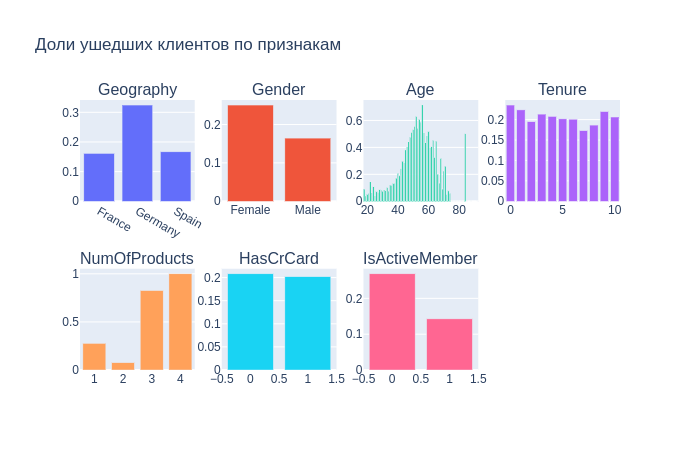

In [ ]:
cols = ['Geography', 'Gender', 'Age', 'Tenure', 
       'NumOfProducts', 'HasCrCard', 'IsActiveMember']
fig = make_subplots(rows=2, cols=4, subplot_titles=cols)
i, j = 1, 1

for col in cols:   
    q = df.groupby(col).Exited.mean().reset_index()
    fig.add_trace(go.Bar(x=q.iloc[:, 0], y=q.iloc[:, 1]),
                  row=j, col=i
                  ) 
    
    fig.update_layout(title='Доли ушедших клиентов по признакам', 
                      showlegend=False
                      )  
    i += 1
    if i == 5:
        i, j = 1, 2     
  
fig.show('png') 

Сделаем то же самое для численных признаков.  
Для начала разобъем значения этих признаков на интервалы.

In [ ]:
num_features = ['CreditScore', 'Balance', 'EstimatedSalary']
num_features_cut = []

for col in num_features:
    name = col + '_cut'
    df[name] = pd.qcut(df[col], 10, duplicates='drop')
    num_features_cut.append(name)

Построим графики.

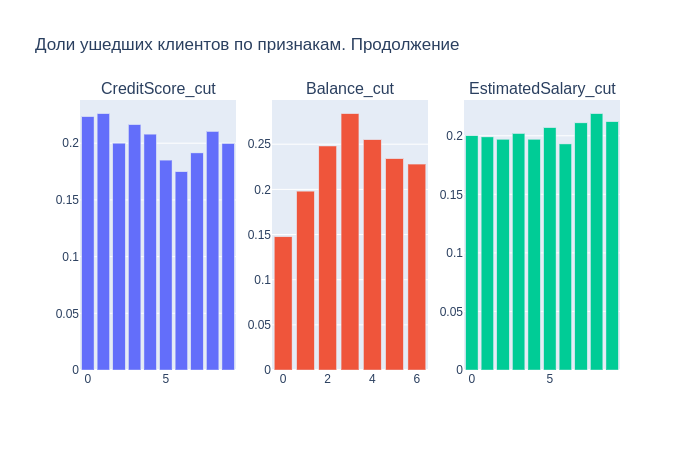

In [ ]:
fig = make_subplots(rows=1, cols=3, subplot_titles=num_features_cut)

for col in num_features_cut:        
    q = df.groupby(col).Exited.mean().reset_index()
    fig.add_trace(go.Bar(x=q.index, y=q.iloc[:, 1]),
                  row=1, col=num_features_cut.index(col) + 1
                  )                
fig.update_layout(title='Доли ушедших клиентов по признакам. Продолжение', 
                  showlegend=False
                  )  
fig.show('png') 

Мы видим, что такие признаки как страна проживания, пол, возраст, количество продуктов и активность можно выделить в качестве наиболее весомых. Сюда же можно добавить баланс на счете.  

По результатам проведенного анализа мы убедились в малой значимости признака `Tenure`. Примем решение не использовать его.  
Можно убедиться в получении более высоких значений метрик качества при таком подходе по сравнению с удалением пропущенных значений. Замену пропусков для данного случая мы не рассматриваем, т.к. лучше не учитывать пропуски, чем потенциально искажать данные в результате их замены, тем более, что размер выборки относительно большой.

In [ ]:
# отбросим ранее созданные столбцы из списка num_features_cut и удалим Tenure
data = df.iloc[:, :-3].drop('Tenure', axis=1)

Применим порядковое кодирование для дальнейшей работы.

In [ ]:
# применим кодирование сразу ко всем признакам, т.к. дальше будем использовать только RandomForest 
encoder = OrdinalEncoder()
data = pd.DataFrame(encoder.fit_transform(data), columns=data.columns)

Масштабируем численные признаки для визуализации t-SNE.

In [ ]:
# масштабируем только для TSNE, поэтому обучение scaler на всех данных не повлияет на результат
# далее продолжим работать с данными в этом же виде, RandomForest не чувствителен к масштабированию
scaler = StandardScaler()
data[num_features] = pd.DataFrame(scaler.fit_transform(data[num_features]), 
                                  columns=num_features)

Попробуем посмотреть на данные во всех измерениях.  
Воспользуемся алгоритмом стохастического вложения соседей с t-распределением для визуализации всех наших данных.  

In [ ]:
tsne = TSNE(random_state=123)
tsne_representation = tsne.fit_transform(data)

Раскрасим желтым данные об ушедших клиентах. Выделим возраст клиентов размером маркеров.  

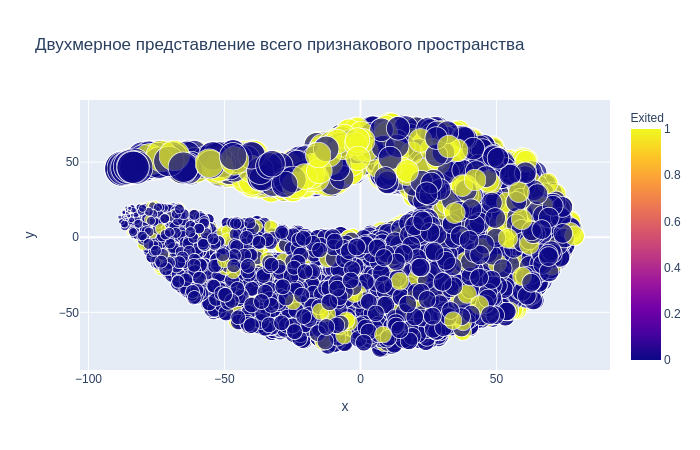

In [ ]:
fig = px.scatter(x=tsne_representation[:, 0], 
                 y=tsne_representation[:, 1], 
                 color=data.Exited,
                 size=data.Age,
                 title='Двухмерное представление всего признакового пространства',
                 labels={'color': 'Exited'}
                 )
fig.show('png')

Мы видим довольно выраженную локализацию ушедших клиентов и подтверждение ранее показанного на столбчатой диаграмме возрастного диапазона склонных к уходу клиентов.  

Отметим, что такая локализация присутствует на фоне всех признаков в их совокупности без сильного превалирования одних над другими.  

Заметим также достаточное присутствие желтых маркеров во всех областях, помимо основной локализации.

<a id="2"></a> 
## 2. Формирование выборок и первое обучение

Разобъем данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1.  

In [ ]:
# разобъем данные в соотношении 80/20 для выделения тестовой выборки
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :-1], 
                                                    data.iloc[:, -1], 
                                                    test_size=0.2, 
                                                    random_state=123
                                                   )

# разобъем 80% в соотношении 3:1 и получим обучающую и валидационную выборки
X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                                                  y_train, 
                                                  test_size=0.25, # 0.25 x 0.8 = 0.2
                                                  random_state=123
                                                 ) 

В качестве бейслайна выберем RandomForestClassifier с параметрами по умолчанию.  
Оценим результаты на валидационной выборке.

In [ ]:
rfc = RandomForestClassifier(random_state=123)
rfc.fit(X_train, y_train)
predicted_valid = rfc.predict(X_valid)
print(classification_report(y_valid, predicted_valid))

              precision    recall  f1-score   support

         0.0       0.87      0.97      0.91      1580
         1.0       0.78      0.44      0.56       420

    accuracy                           0.86      2000
   macro avg       0.82      0.70      0.74      2000
weighted avg       0.85      0.86      0.84      2000



Построим ROC-кривую и вычислим площадь под ней.

In [ ]:
def auc_roc(clf, X, y, show_graph=False):
    probas_valid = clf.predict_proba(X)
    fpr, tpr, thresholds = roc_curve(y, probas_valid[:, 1]) 
    auc_roc = roc_auc_score(y, probas_valid[:, 1]) 
 
    if show_graph:   
        fig = px.line(x=fpr, y=tpr, width=500, height=500, 
                      labels={'x': 'FPR', 'y': 'TPR'}, 
                      title='ROC-кривая. AUC-ROC: ' + str(auc_roc)
                      )
        fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], showlegend=False))
        fig.update_xaxes(nticks=10)
        fig.show('png')
        
    return auc_roc

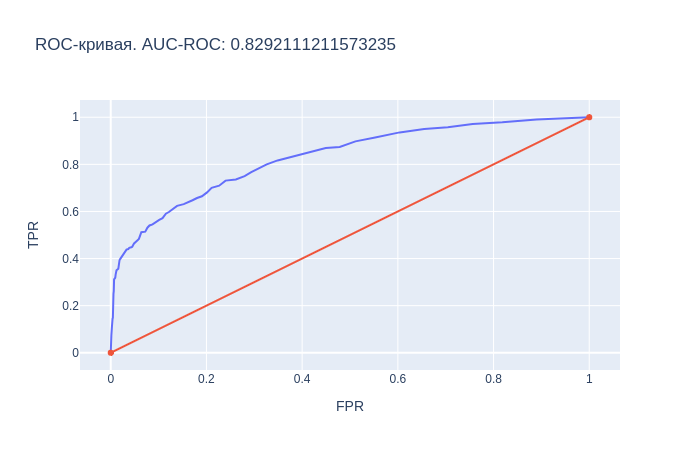

0.8292111211573235

In [ ]:
auc_roc(rfc, X_valid, y_valid, show_graph=True)

Попробуем улучшить модель. Выберем параметры на кросс-валидации.

In [ ]:
rfc_params = {'n_estimators': [300, 600],           
              'max_depth': [10, 20, 50], 
             }

rfc_cv = GridSearchCV(rfc, rfc_params)
rfc_cv.fit(X_train, y_train)
rfc_cv.best_params_

{'max_depth': 10, 'n_estimators': 600}

In [ ]:
predicted_valid = rfc_cv.predict(X_valid)
print(classification_report(y_valid, predicted_valid))
print('AUC-ROC: ', auc_roc(rfc_cv, X_valid, y_valid))

              precision    recall  f1-score   support

         0.0       0.86      0.97      0.92      1580
         1.0       0.81      0.43      0.56       420

    accuracy                           0.86      2000
   macro avg       0.84      0.70      0.74      2000
weighted avg       0.85      0.86      0.84      2000

AUC-ROC:  0.8463713080168775


Нам удалось получить более высокое значение AUC-ROC, но значения метрик качества по интересующему нас классу по-прежнему низки.  
Необходимо преодолеть дисбаланс классов и улучшить качество модели.

<a id="3"></a> 
## 3. Преодоление дисбаланса и повторное обучение

<a id="3_1"></a> 
### Взвешивание классов

Применим технику взвешивания классов. Придадим больший вес объектам редкого класса.

Рассмотрим различные веса в цикле.

In [ ]:
metrics_weighted = []
for i in range(4):
    rfc_weighted = RandomForestClassifier(max_depth=10, 
                                          n_estimators=600, 
                                          class_weight=('balanced' if i==0 
                                                        else {0: 1, 1: i}), 
                                          random_state=123)
    rfc_weighted.fit(X_train, y_train)
    predicted_valid = rfc_weighted.predict(X_valid)
    metrics_weighted.append([i, f1_score(y_valid, predicted_valid),
              auc_roc(rfc_weighted, X_valid, y_valid)]
             )

metrics_weighted = np.array(metrics_weighted)

Построим график.

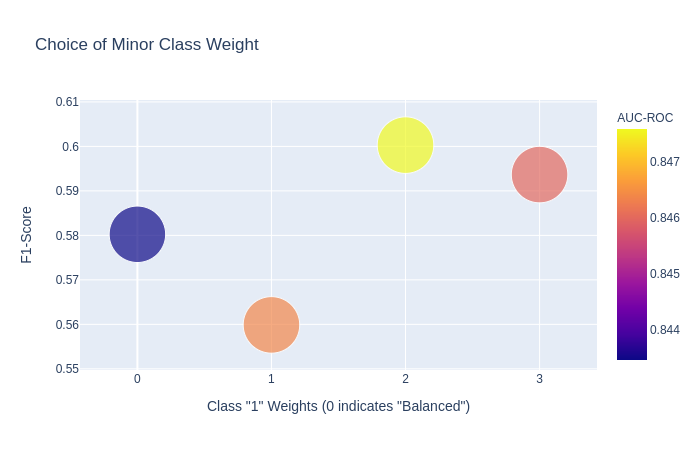

In [ ]:
fig = px.scatter(x=metrics_weighted[:, 0], y=metrics_weighted[:, 1], 
                 color=metrics_weighted[:, 2], 
                 size=metrics_weighted[:, 2], size_max=40,   
                 width=600, height=500,
                 title='Choice of Minor Class Weight',
                 labels={'x': 'Class "1" Weights (0 indicates "Balanced")',
                         'y': 'F1-Score',
                         'color': 'AUC-ROC'
                         }
                 )
fig.show('png')

Мы видим, что вариант `{0: 1, 1: 2}` показывает наилучший результат.  
Проанализируем его более подробно. 

              precision    recall  f1-score   support

         0.0       0.88      0.96      0.92      1580
         1.0       0.76      0.50      0.60       420

    accuracy                           0.86      2000
   macro avg       0.82      0.73      0.76      2000
weighted avg       0.85      0.86      0.85      2000



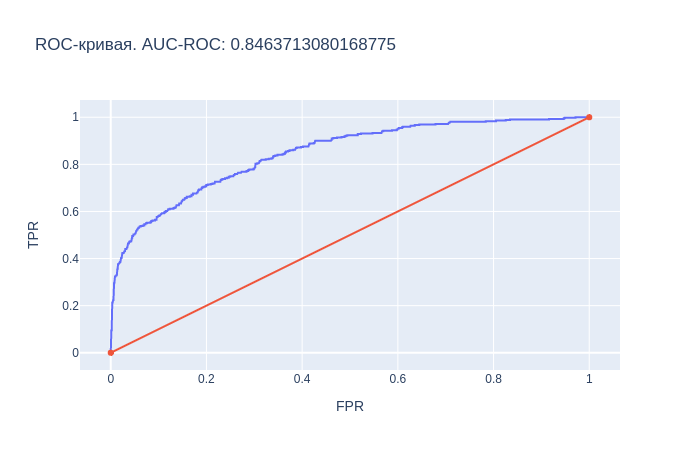

AUC-ROC:  0.8463713080168775


In [ ]:
rfc_weighted = RandomForestClassifier(max_depth=10,
                                      n_estimators=600,
                                      class_weight={0: 1, 1: 2}, 
                                      random_state=123)
rfc_weighted.fit(X_train, y_train)
predicted_valid = rfc_weighted.predict(X_valid)
print(classification_report(y_valid, predicted_valid))
print('AUC-ROC: ', auc_roc(rfc_cv, X_valid, y_valid, show_graph=True))

Нам удалось увеличить значение f1-меры до 0.6, сохраняя достигнутый уровень AUC-ROC. При этом заметим, что на фоне достижения большей полноты мы несколько потеряли в точности по классу 1.

<a id="3_2"></a> 
### Увеличиение и уменьшение выборки. Дублирование и удаление.

Рассмотрим варианты увеличения и уменьшения выборки для значений редкого и частого классов соответственно.

In [ ]:
def resampler(X, y, k=1, up=True):
    """Oversample the minority class or undersample the majority class.
    Parameters
    ----------
    X : Pandas.DataFrame
        Features.
    y : Pandas.DataFrame
        Targets.
    k : int or float, default=1
        Sampling factor. Set as float fraction if `up=False`.
    up : bool, default=True
        If True, data will be oversampled; else, it will be undersampled.
    Returns
    -------
    X_resampled : Pandas.DataFrame
        Resampled data.
    y_resampled : Pandas.DataFrame
        The corresponding labels of X_resampled.
    """
    
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    if up:
        X_resampled = pd.concat([X_zeros] + [X_ones] * k)
        y_resampled = pd.concat([y_zeros] + [y_ones] * k)    
        X_resampled, y_resampled = shuffle(X_resampled, y_resampled, 
                                          random_state=12345)        
    else:
        X_resampled = pd.concat(
            [X_zeros.sample(frac=k, random_state=12345)] + [X_ones])    
        y_resampled = pd.concat(
            [y_zeros.sample(frac=k, random_state=12345)] + [y_ones])
        
    return X_resampled, y_resampled

Переберем сочетания коэффициентов увеличения количества записей по ушедшим клиентам и долей уменьшения количества остальных записей. Сохраним в `metrics_data` данные о вышеуказанных коэффициентах, долях и соответствующих им значениях F1-меры и AUC-ROC.

In [ ]:
rfc_resampled = RandomForestClassifier(max_depth=10, 
                                       n_estimators=600, 
                                       random_state=123)

In [ ]:
metrics_resampled = []

for i in range(1, 6):
    for j in range(5, 10):
        X_train_sampled, y_train_sampled = resampler(X_train, y_train, k=i)
        X_train_sampled, y_train_sampled = resampler(X_train_sampled, 
                                                     y_train_sampled, 
                                                     up=False, k=j*.1)
        
        
        rfc_resampled.fit(X_train_sampled, y_train_sampled)

        predicted_valid = rfc_resampled.predict(X_valid)
        row = [i, j*.1, f1_score(y_valid, predicted_valid), 
               auc_roc(rfc_resampled, X_valid, y_valid)]

        metrics_resampled.append(row)

Построим график.

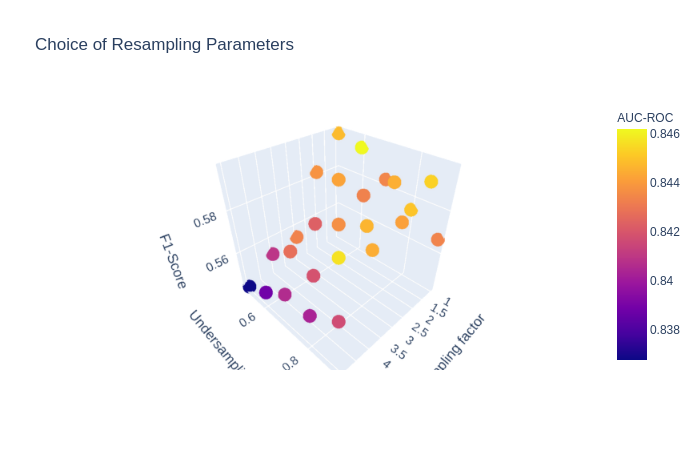

In [ ]:
metrics_resampled = np.array(metrics_resampled)
fig = px.scatter_3d(x=metrics_resampled[:,0],
                    y=metrics_resampled[:,1],
                    z=metrics_resampled[:,2], 
                    color=metrics_resampled[:,3],
                    height=750, width=900,
                    title='Choice of Resampling Parameters',
                    labels={'x': 'Oversampling factor',
                            'y': 'Undersampling factor',
                            'z': 'F1-Score',
                            'color': 'AUC-ROC'
                            }
                        )
fig.show('png')

Пользуясь графиком, выберем вариант уменьшения количества объектов частого класса с коэффициентом 0,5 и построим модель.


              precision    recall  f1-score   support

         0.0       0.89      0.92      0.90      1580
         1.0       0.65      0.55      0.60       420

    accuracy                           0.84      2000
   macro avg       0.77      0.74      0.75      2000
weighted avg       0.84      0.84      0.84      2000



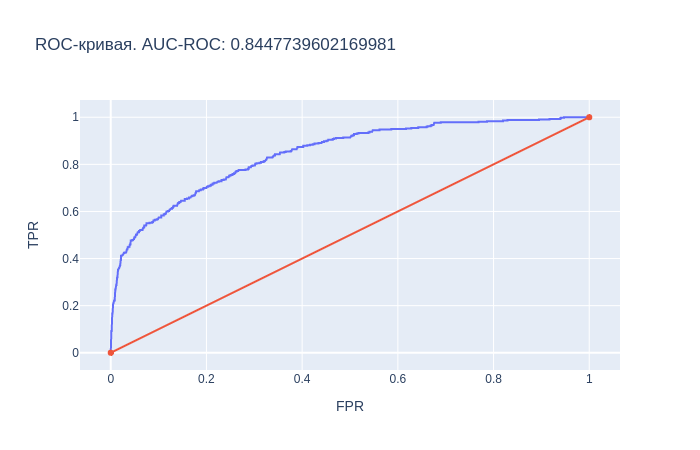

0.8447739602169981

In [ ]:
X_train_sampled, y_train_sampled = resampler(X_train, y_train)
X_train_sampled, y_train_sampled = resampler(X_train_sampled, 
                                             y_train_sampled, 
                                             k=.5, up=False)

rfc_resampled.fit(X_train_sampled, y_train_sampled)
predicted_valid = rfc_resampled.predict(X_valid)

print(classification_report(y_valid, predicted_valid))
auc_roc(rfc_resampled, X_valid, y_valid, show_graph=True)

Как видим, формально на предыдущей модели в целом мы имели несколько лучшие результаты, но в отношении исследуемых метрик они примерно одинаковы. Отметим, что текущая модель дает лучшие значения полноты для интересующего нас класса 1 (0.55 против 0.50 на предыдущей модели).

<a id="3_3"></a> 
### Увеличиение и уменьшение выборки. SMOTE, SMOTETomek и TomekLinks

Применим готовые реализации методов ресэмплинга из библиотеки `imblearn`.
Выберем SMOTE для увеличения выборки, SMOTETomek для уменьшения выборки, а также комбинированный метод TomekLinks.  
Используем каждый из них и сравним результаты.

In [ ]:
sms = [SMOTE, SMOTETomek, TomekLinks]
metrics_data = []

for sm in sms:
    m = sm()
    X_res, y_res = m.fit_resample(X_train, y_train)
    rfc_sm = RandomForestClassifier(max_depth=50, 
                                    n_estimators=600, 
                                    random_state=123)
    rfc_sm.fit(X_res, y_res)

    predicted_valid = rfc_sm.predict(X_valid)

    metrics_data.append([f1_score(y_valid, predicted_valid),
               auc_roc(rfc_sm, X_valid, y_valid)]
              )

Построим график.

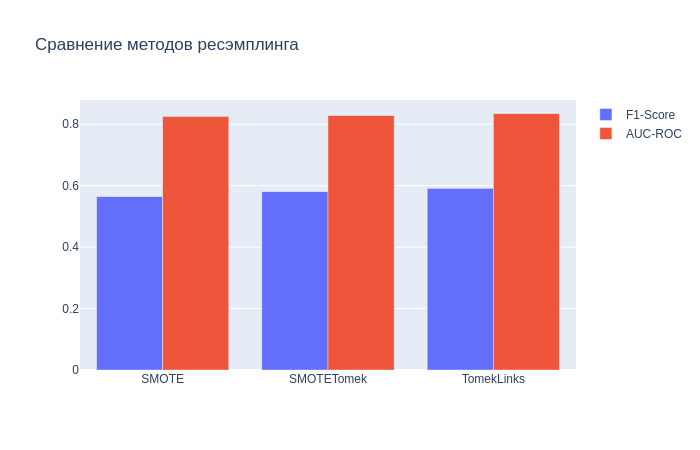

In [ ]:
metrics_data = np.array(metrics_data)
sms = ['SMOTE', 'SMOTETomek', 'TomekLinks']
fig = go.Figure(data=[
    go.Bar(name='F1-Score', x=sms, y=metrics_data[:, 0], ),
    go.Bar(name='AUC-ROC', x=sms, y=metrics_data[:, 1])
])
fig.update_layout(title='Сравнение методов ресэмплинга', barmode='group')
fig.show('png')

Лучшие значения получены при использовании метода TomekLinks.

Таким образом, мы увидели, что работа с дисбалансом привела к повышению качества, при этом все использованные методы показывают довольно близкие результаты.  

<a id="4"></a> 
## 4. Проверка качества моделей на тестовой выборке

Проверим качество рассмотренных классификаторов на тестовой выборке.

Сведем основные метрики в одну таблицу и отсортируем по значениям F1-меры, полученным при использовании различных методов ресэмплинга и без нгего.

In [ ]:
def metrics(clf):
    pred = clf.predict(X_test)
    result = {'Precision': precision_score(y_test, pred), 
              'Recall': recall_score(y_test, pred), 
              'Accuracy': accuracy_score(y_test, pred),
              'F1-Score': f1_score(y_test, pred),              
              'AUC-ROC': auc_roc(clf, X_test, y_test) 
             }
    return result

In [ ]:
clf_dict = {'Disbalance': rfc_cv, 
            'Weighing': rfc_weighted, 
            'Naive Resampling': rfc_resampled, 
            'TomekLinks Resampling': rfc_sm
           }

_ = []
for key, clf in clf_dict.items():  
    _.append(pd.DataFrame(metrics(clf), index=[key]))

df_scores = pd.concat(_).sort_values(by='F1-Score', ascending=False)   
display(df_scores)

,Precision,Recall,Accuracy,F1-Score,AUC-ROC
Naive Resampling,0.669444,0.582126,0.8540,0.622739,0.865264
TomekLinks Resampling,0.715254,0.509662,0.8565,0.595205,0.854482
Weighing,0.703333,0.509662,0.8540,0.591036,0.869911
Disbalance,0.784141,0.429952,0.8575,0.555382,0.868548


Покажем распределение значений F1-меры и AUC-ROC на графике.

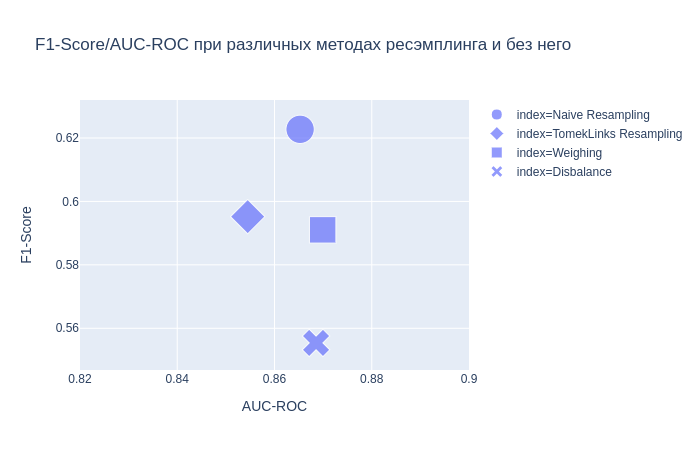

In [ ]:
fig = px.scatter(df_scores.reset_index(), 
                 x='AUC-ROC', y='F1-Score', 
                 symbol='index', range_x=(0.82,0.9), 
                 size='Recall',
                 title='F1-Score/AUC-ROC при различных методах ресэмплинга и без него')
fig.show('png')

<a id="6"></a> 
## Выводы

В рамках настоящей работы мы рассмотрели данные об оттоке клиентов банка.

Мы построили и пронализировали модели классификации для прогнозирования возможного оттока, используя различные методы борьбы с дисбалансом классов.  

В вопросе оценки качества мы опирались на такие метрики как f1-мера и ROC-AUC, дополнительно дополнительно рассматривая значения точности и полноты.

Мы показали, что уменьшение дисбаланса классов позволяет добиться более выского уровня качетсва.  

При всех использованных методах борьбы с дисбалансом нам удалось получить значение f1-меры более 0.59 (до 0.62) при AUC-ROC на уровне порядка 0.86.